In [ ]:
%%configure
{"vCores": 64 }

# Install Package

In [ ]:
!pip install -q deltalake   --upgrade
!pip install -q pandas      --upgrade
!pip install -q duckdb      --upgrade
notebookutils.session.restartPython()

***Import***

In [ ]:
import pandas    as pd
from   datetime  import datetime
from   psutil    import *
from   deltalake import write_deltalake , DeltaTable
import time
import os
import duckdb

In [ ]:
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=int(virtual_memory().total/(1024 * 1024 * 1024))
print(vCPU +' Memory:'+ str(mem))

**disk size**

In [ ]:
!df -h /mnt/notebookfusetmp | awk 'NR==2 {print $4}'

In [ ]:
ws                 = 'bigdata'
lh                 = 'tpch'
result_path        = 'abfss://sqlengines@onelake.dfs.fabric.microsoft.com/benchmarks.Lakehouse/Tables/dbo/result'
Table_Path_abfss   = f'abfss://{ws}@onelake.dfs.fabric.microsoft.com/{lh}.Lakehouse/Tables'

# Generate Data

In [ ]:
tpch_tables = ['nation','region','customer','supplier','partsupp','part','lineitem','orders']
Table_Path = '/lakehouse/default/Tables'

def define_schema(SF):
    return "CH" + f"{SF:g}".replace('.', '_').zfill(5)

def generate_data(SF):
    import pathlib
    import time
    from datetime import timedelta
    
    schema = define_schema(SF)
    BASE_OUTPUT_DIR = f"{Table_Path}/{schema}"
    
    # Track status and timing for each table
    status = {table: {'status': 'pending', 'time': 0} for table in tpch_tables}
    
    # Check which tables already exist as Delta tables
    for tbl in tpch_tables:
        table_path = pathlib.Path(f'{BASE_OUTPUT_DIR}/{tbl}')
        delta_log_path = table_path / '_delta_log'
        
        if table_path.exists():
            if delta_log_path.exists():
                status[tbl]['status'] = 'exists_delta'
                print(f"✓ Table {tbl} exists as Delta table, skipping")
            else:
                status[tbl]['status'] = 'exists_parquet_only'
                print(f"⚠ Table {tbl} exists but only as Parquet (no Delta metadata), will convert")
    
    # Process tables that don't exist or need Delta conversion
    tables_to_generate = [tbl for tbl in tpch_tables if status[tbl]['status'] == 'pending']
    tables_to_convert = [tbl for tbl in tpch_tables if status[tbl]['status'] == 'exists_parquet_only']
    
    if not tables_to_generate and not tables_to_convert:
        print("All tables already exist as Delta tables!")
        return status
    
    if tables_to_generate:
        print(f"\nTables to generate: {tables_to_generate}")
    if tables_to_convert:
        print(f"\nTables to convert to Delta: {tables_to_convert}")
    
    # Install dependencies only if needed
    if tables_to_generate or tables_to_convert:
        print("\nInstalling dependencies...")
        if tables_to_generate:
            !pip install -q tpchgen-cli
        from deltalake import convert_to_deltalake
    
    # Configuration for each table
    table_config = {
        'lineitem': max(1, int(100 * (SF/1000))),
        'orders'  : max(1, int(35 * (SF/1000))),
        'partsupp': max(1, int(20 * (SF/1000))),
        'part'    : max(1, int(4 * (SF/1000))),
        'customer': max(1, int(6 * (SF/1000))),
        'supplier': max(1, int(0.5 * (SF/1000))),
        'region'  : 1,
        'nation'  : 1
    }
    
    total_start_time = time.time()
    
    # Process each table individually
    for tbl in tpch_tables:
        if status[tbl]['status'] == 'exists_delta':
            continue
        
        table_start_time = time.time()
        
        try:
            print(f"\n{'='*60}")
            print(f"Processing table: {tbl}")
            print(f"{'='*60}")
            
            # Generate parquet if needed
            if status[tbl]['status'] == 'pending':
                parts = table_config[tbl]
                
                print(f"Generating parquet data for: {tbl}")
                gen_start = time.time()
                !tpchgen-cli -s {SF} --tables {tbl} --output-dir {BASE_OUTPUT_DIR} --parts {parts} --format parquet --parquet-row-group-bytes=268435456
                gen_time = time.time() - gen_start
                print(f"  Generation time: {timedelta(seconds=int(gen_time))}")
                status[tbl]['gen_time'] = gen_time
            else:
                print(f"Parquet data already exists for: {tbl}")
                status[tbl]['gen_time'] = 0
            
            # Convert to Delta
            print(f"Converting to Delta: {tbl}")
            delta_start = time.time()
            convert_to_deltalake(f'{BASE_OUTPUT_DIR}/{tbl}', storage_options={"allow_unsafe_rename":"true"})
            delta_time = time.time() - delta_start
            
            table_total_time = time.time() - table_start_time
            
            status[tbl]['status'] = 'success'
            status[tbl]['time'] = table_total_time
            status[tbl]['delta_time'] = delta_time
            
            print(f"✓ Successfully processed: {tbl}")
            print(f"  Delta conversion: {timedelta(seconds=int(delta_time))}")
            print(f"  Total time: {timedelta(seconds=int(table_total_time))}")
            
        except Exception as e:
            table_total_time = time.time() - table_start_time
            status[tbl]['status'] = f'failed'
            status[tbl]['error'] = str(e)
            status[tbl]['time'] = table_total_time
            print(f"✗ Failed to process {tbl}: {e}")
            print(f"  Time before failure: {timedelta(seconds=int(table_total_time))}")
            print(f"Continuing with remaining tables...")
    
    total_time = time.time() - total_start_time
    
    # Print final status report
    print(f"\n{'='*60}")
    print("GENERATION SUMMARY")
    print(f"{'='*60}")
    print(f"{'Table':<15} {'Status':<20} {'Time':<15}")
    print(f"{'-'*60}")
    
    for tbl in tpch_tables:
        tbl_status = status[tbl]['status']
        tbl_time = status[tbl]['time']
        
        if tbl_status == 'exists_delta':
            print(f"{tbl:<15} {'✓ Delta exists':<20} {'-':<15}")
        elif tbl_status == 'success':
            time_str = str(timedelta(seconds=int(tbl_time)))
            print(f"{tbl:<15} {'✓ Success':<20} {time_str:<15}")
        elif tbl_status == 'failed':
            time_str = str(timedelta(seconds=int(tbl_time)))
            print(f"{tbl:<15} {'✗ FAILED':<20} {time_str:<15}")
        else:
            print(f"{tbl:<15} {tbl_status:<20} {'-':<15}")
    
    print(f"{'-'*60}")
    print(f"Total execution time: {timedelta(seconds=int(total_time))}")
    print(f"{'='*60}")
    return status

# SQL Query

In [ ]:
def sql_query(SF):
   return f'''
        SELECT
            --Query01
            l_returnflag,
            l_linestatus,
            SUM(l_quantity) AS sum_qty,
            SUM(l_extendedprice) AS sum_base_price,
            SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
            SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
            AVG(l_quantity) AS avg_qty,
            AVG(l_extendedprice) AS avg_price,
            AVG(l_discount) AS avg_disc,
            COUNT(*) AS count_order
        FROM
            lineitem
        WHERE
            l_shipdate <= CAST('1998-09-02' AS date)
        GROUP BY
            l_returnflag,
            l_linestatus
        ORDER BY
            l_returnflag,
            l_linestatus;



        WITH cheapest_part AS (
            SELECT
                MIN(ps.ps_supplycost) AS cp_lowest,
                p.p_partkey AS cp_partkey
            FROM part p
            JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
            JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
            JOIN nation n ON s.s_nationkey = n.n_nationkey
            JOIN region r ON n.n_regionkey = r.r_regionkey
            WHERE r.r_name = 'EUROPE'
            GROUP BY p.p_partkey
        )
        SELECT
            s.s_acctbal,
            s.s_name,
            n.n_name,
            p.p_partkey,
            p.p_mfgr,
            s.s_address,
            s.s_phone,
            s.s_comment
        FROM part p
        JOIN partsupp ps ON p.p_partkey = ps.ps_partkey
        JOIN supplier s ON s.s_suppkey = ps.ps_suppkey
        JOIN nation n ON s.s_nationkey = n.n_nationkey
        JOIN region r ON n.n_regionkey = r.r_regionkey
        JOIN cheapest_part cp ON ps.ps_supplycost = cp.cp_lowest AND cp.cp_partkey = p.p_partkey
        WHERE p.p_size = 15
        AND p.p_type LIKE '%BRASS'
        AND r.r_name = 'EUROPE'
        ORDER BY s.s_acctbal DESC,
                n.n_name,
                s.s_name,
                p.p_partkey
        LIMIT 10;









        SELECT
            l.l_orderkey,
            SUM(l.l_extendedprice * (1 - l.l_discount)) AS revenue,
            o.o_orderdate,
            o.o_shippriority
        FROM
            customer c
        JOIN orders o ON c.c_custkey = o.o_custkey
        JOIN lineitem l ON l.l_orderkey = o.o_orderkey
        WHERE
            c.c_mktsegment = 'BUILDING'
            AND o.o_orderdate < CAST('1995-03-15' AS DATE)
            AND l.l_shipdate > CAST('1995-03-15' AS DATE)
        GROUP BY
            l.l_orderkey,
            o.o_orderdate,
            o.o_shippriority
        ORDER BY
            revenue DESC,
            o.o_orderdate
        LIMIT 10;









        select
        --Query04
            o_orderpriority,
            count(*) as order_count
        from
            orders
        where
            o_orderdate >= cast('1993-07-01' as date)
            and o_orderdate < cast('1993-10-01' as date)
            and o_orderkey in (
                select
                    l_orderkey
                from
                    lineitem
                where
                    l_commitdate < l_receiptdate
            )
        group by
            o_orderpriority
        order by
            o_orderpriority;




        SELECT
            --Query05
            n_name,
            SUM(l_extendedprice * (1 - l_discount)) AS revenue
        FROM lineitem
        inner join (select * from orders where o_orderdate >= '1994-01-01' AND o_orderdate < '1995-01-01') as x
        on l_orderkey = x.o_orderkey
        left join supplier
        on l_suppkey = s_suppkey
        left join customer
        on o_custkey = c_custkey and
        c_nationkey = s_nationkey
        left join nation
        on s_nationkey = n_nationkey
        inner join ( select * from region where r_name = 'ASIA') as xx
        on n_regionkey = xx.r_regionkey

        GROUP BY
            n_name
        ORDER BY
            revenue DESC;


        SELECT
            --Query06
            SUM(l_extendedprice * l_discount) AS revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1994-01-01' AS date)
            AND l_shipdate < CAST('1995-01-01' AS date)
            AND l_discount BETWEEN 0.05
            AND 0.07
            AND l_quantity < 24;







        SELECT
            --Query07
            supp_nation,
            cust_nation,
            l_year,
            SUM(volume) AS revenue
        FROM (
            SELECT
                n1.n_name AS supp_nation,
                n2.n_name AS cust_nation,
                EXTRACT(YEAR FROM l.l_shipdate) AS l_year,
                l.l_extendedprice * (1 - l.l_discount) AS volume
            FROM
                supplier s
            JOIN lineitem l ON s.s_suppkey = l.l_suppkey
            JOIN orders o ON o.o_orderkey = l.l_orderkey
            JOIN customer c ON c.c_custkey = o.o_custkey
            JOIN nation n1 ON s.s_nationkey = n1.n_nationkey
            JOIN nation n2 ON c.c_nationkey = n2.n_nationkey
            WHERE
                (n1.n_name = 'FRANCE' AND n2.n_name = 'GERMANY')
                OR (n1.n_name = 'GERMANY' AND n2.n_name = 'FRANCE')
                AND l.l_shipdate BETWEEN CAST('1995-01-01' AS DATE) AND CAST('1996-12-31' AS DATE)
        ) AS shipping
        GROUP BY
            supp_nation,
            cust_nation,
            l_year
        ORDER BY
            supp_nation,
            cust_nation,
            l_year;








        SELECT
            --Query08
                EXTRACT( year  FROM  o_orderdate ) AS o_year,
                SUM(  CASE  WHEN n2.n_name = 'BRAZIL' THEN l_extendedprice * (1 - l_discount) ELSE 0  END ) / SUM(l_extendedprice * (1 - l_discount)) AS mkt_share
                FROM  lineitem
                inner join   (select o_custkey,o_orderdate, o_orderkey from  orders WHERE  o_orderdate BETWEEN CAST('1995-01-01' AS date) AND CAST('1996-12-31' AS date) ) xxx
                on l_orderkey = xxx.o_orderkey
                inner join  (select p_partkey from  part  where p_type = 'ECONOMY ANODIZED STEEL' ) z
                on  l_partkey = z.p_partkey
                left join    supplier
                on  l_suppkey = s_suppkey
                left join   customer
                on o_custkey = c_custkey
                left join   nation n1
                on c_nationkey = n1.n_nationkey
                left join   nation n2
                on s_nationkey = n2.n_nationkey
                inner join  (select * from region where r_name = 'AMERICA') cc
                on  n1.n_regionkey = cc.r_regionkey




        GROUP BY
            o_year
        ORDER BY
            o_year;










        SELECT
            --Query09
            n_name AS nation,
            EXTRACT( year  FROM o_orderdate ) AS o_year,
            sum(l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity) AS sum_profit
                FROM lineitem
                inner join ( select p_partkey from part where  p_name LIKE '%green%') xx
                on  l_partkey = xx.p_partkey
                left join orders
                on  l_orderkey =o_orderkey
                left join  partsupp
                on  l_suppkey =ps_suppkey  AND  l_partkey = ps_partkey
                left join  supplier
                on    l_suppkey =s_suppkey
                left join nation
                on  n_nationkey = s_nationkey


        GROUP BY
            n_name,
            o_year
        ORDER BY
            n_name,
            o_year DESC;



        SELECT
            --Query10
            c_custkey,
            c_name,
            SUM(l_extendedprice * (1 - l_discount)) AS revenue,
            c_acctbal,
            n_name,
            c_address,
            c_phone,
            c_comment
        FROM  lineitem
        inner join ( select * from orders where o_orderdate >= '1993-10-01' AND o_orderdate < '1994-01-01') as xx
        on l_orderkey = xx.o_orderkey
        left join customer
        on xx.o_custkey = c_custkey
        left join nation
        on c_nationkey = n_nationkey
        WHERE  l_returnflag = 'R'

        GROUP BY
            c_custkey,
            c_name,
            c_acctbal,
            c_phone,
            n_name,
            c_address,
            c_comment
        ORDER BY
            revenue DESC
        LIMIT
            20;







        SELECT
            ps.ps_partkey,
            SUM(ps.ps_supplycost * ps.ps_availqty) AS value
        FROM
            partsupp ps
        JOIN supplier s ON ps.ps_suppkey = s.s_suppkey
        JOIN nation n ON s.s_nationkey = n.n_nationkey
        WHERE
            n.n_name = 'GERMANY'
        GROUP BY
            ps.ps_partkey
        HAVING
            SUM(ps.ps_supplycost * ps.ps_availqty) > (
                SELECT
                    SUM(ps_inner.ps_supplycost * ps_inner.ps_availqty) * (0.0001 / {SF})
                FROM
                    partsupp ps_inner
                JOIN supplier s_inner ON ps_inner.ps_suppkey = s_inner.s_suppkey
                JOIN nation n_inner ON s_inner.s_nationkey = n_inner.n_nationkey
                WHERE
                    n_inner.n_name = 'GERMANY'
            )
        ORDER BY
            value DESC;









        SELECT
            --Query12
            l_shipmode,
            SUM(
                CASE
                    WHEN o_orderpriority = '1-URGENT'
                    OR o_orderpriority = '2-HIGH' THEN 1
                    ELSE 0
                END
            ) AS high_line_count,
            SUM(
                CASE
                    WHEN o_orderpriority <> '1-URGENT'
                    AND o_orderpriority <> '2-HIGH' THEN 1
                    ELSE 0
                END
            ) AS low_line_count
        FROM lineitem
        left join  orders
        on o_orderkey = l_orderkey

        WHERE  l_shipmode IN ('MAIL', 'SHIP')
            AND l_commitdate < l_receiptdate
            AND l_shipdate < l_commitdate
            AND l_receiptdate >=  '1994-01-01'  AND l_receiptdate < '1995-01-01'
        GROUP BY
            l_shipmode
        ORDER BY
            l_shipmode;








        SELECT
            --Query13
            c_count,
            COUNT(*) AS custdist
        FROM
            (
                SELECT
                    c_custkey,
                    COUNT(o_orderkey) AS c_count
                FROM
                    customer
                    LEFT OUTER JOIN orders ON c_custkey = o_custkey
                    AND o_comment NOT LIKE '%special%requests%'
                GROUP BY
                    c_custkey
            ) AS c_orders
        GROUP BY
            c_count
        ORDER BY
            custdist DESC,
            c_count DESC;








        SELECT
            --Query14
            100.00 * SUM(
                CASE
                    WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
                    ELSE 0
                END
            ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
        FROM  lineitem
        left join part
        on l_partkey = p_partkey
        WHERE l_shipdate >= cast('1995-09-01' as date) AND l_shipdate < cast('1995-10-01' as date);








        SELECT
            --Query15
            s_suppkey,
            s_name,
            s_address,
            s_phone,
            total_revenue
        FROM
            supplier,
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue0
        WHERE
            s_suppkey = supplier_no
            AND total_revenue = (
                SELECT
                    MAX(total_revenue)
                FROM
                    (
                        SELECT
                            l_suppkey AS supplier_no,
                            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                        FROM
                            lineitem
                        WHERE
                            l_shipdate >= CAST('1996-01-01' AS date)
                            AND l_shipdate < CAST('1996-04-01' AS date)
                        GROUP BY
                            l_suppkey
                    ) revenue1
            )
        ORDER BY
            s_suppkey;








        SELECT
            --Query16
            p.p_brand,
            p.p_type,
            p.p_size,
            COUNT(DISTINCT ps.ps_suppkey) AS supplier_cnt
        FROM
            partsupp ps
        JOIN part p ON p.p_partkey = ps.ps_partkey
        WHERE
            p.p_brand <> 'Brand#45'
            AND p.p_type NOT LIKE 'MEDIUM POLISHED%'
            AND p.p_size IN (49, 14, 23, 45, 19, 3, 36, 9)
            AND ps.ps_suppkey NOT IN (
                SELECT
                    s.s_suppkey
                FROM
                    supplier s
                WHERE
                    s.s_comment LIKE '%Customer%Complaints%'
            )
        GROUP BY
            p.p_brand,
            p.p_type,
            p.p_size
        ORDER BY
            supplier_cnt DESC,
            p.p_brand,
            p.p_type,
            p.p_size;









        WITH part_avg AS (
            -- Query17
            SELECT
                (0.2 * AVG(l.l_quantity)) AS limit_qty,
                l.l_partkey AS lpk
            FROM lineitem l
            GROUP BY l.l_partkey
        )
        SELECT
            SUM(l.l_extendedprice) / 7.0 AS avg_yearly
        FROM
            lineitem l
        JOIN part p ON p.p_partkey = l.l_partkey
        JOIN part_avg pa ON p.p_partkey = pa.lpk
        WHERE
            p.p_brand = 'Brand#23'
            AND p.p_container = 'MED BOX'
            AND l.l_quantity < pa.limit_qty;







        SELECT
            --Query18
            c.c_name,
            c.c_custkey,
            o.o_orderkey,
            o.o_orderdate,
            o.o_totalprice,
            SUM(l.l_quantity)
        FROM
            customer c
        JOIN orders o ON c.c_custkey = o.o_custkey
        JOIN lineitem l ON o.o_orderkey = l.l_orderkey
        WHERE
            o.o_orderkey IN (
                SELECT
                    l_orderkey
                FROM
                    lineitem
                GROUP BY
                    l_orderkey
                HAVING
                    SUM(l_quantity) > 300
            )
        GROUP BY
            c.c_name,
            c.c_custkey,
            o.o_orderkey,
            o.o_orderdate,
            o.o_totalprice
        ORDER BY
            o.o_totalprice DESC,
            o.o_orderdate
        LIMIT
            100;






        select
        --Query19
        sum(l_extendedprice* (1 - l_discount)) as revenue

        from lineitem
        join  part
        ON p_partkey = l_partkey
        where (
                p_brand = 'Brand#12'
                and p_container in ('SM CASE', 'SM BOX', 'SM PACK', 'SM PKG')
                and l_quantity >= 1 and l_quantity <= 1 + 10
                and p_size between 1 and 5
                and l_shipmode in ('AIR', 'AIR REG')
                and l_shipinstruct = 'DELIVER IN PERSON'
            ) or ( p_partkey = l_partkey
                and p_brand = 'Brand#23'
                and p_container in ('MED BAG', 'MED BOX', 'MED PKG', 'MED PACK')
                and l_quantity >= 10 and l_quantity <= 10 + 10
                and p_size between 1 and 10
                and l_shipmode in ('AIR', 'AIR REG')
                and l_shipinstruct = 'DELIVER IN PERSON'
            ) or ( p_partkey = l_partkey
                and p_brand = 'Brand#34'
                and p_container in ('LG CASE', 'LG BOX', 'LG PACK', 'LG PKG')
                and l_quantity >= 20 and l_quantity <= 20 + 10
                and p_size between 1 and 15
                and l_shipmode in ('AIR', 'AIR REG')
                and l_shipinstruct = 'DELIVER IN PERSON'
            );





        --Query20
        with availability_part_supp as(
                select 0.5 * sum(l_quantity) as ps_halfqty, l_partkey as pkey, l_suppkey as skey
                from lineitem
                where l_shipdate >= cast('1994-01-01' as date)
                and l_shipdate < cast('1995-01-01' as date)
                group by pkey, skey
        )
        select s_name, s_address
        from supplier, nation
        where s_suppkey in (
                select ps_suppkey
                from partsupp, availability_part_supp
                where ps_partkey in (
                        select p_partkey
                            from part
                                where p_name like 'forest%'
                                )
                                and ps_partkey = pkey
                                and ps_suppkey = skey
                                and ps_availqty > ps_halfqty
                        )
                        and s_nationkey = n_nationkey
                        and n_name = 'CANADA'
                        order by s_name;






        SELECT
            --Query21
            s.s_name,
            COUNT(*) AS numwait
        FROM
            supplier s
        JOIN lineitem l1 ON s.s_suppkey = l1.l_suppkey
        JOIN orders o ON o.o_orderkey = l1.l_orderkey
        JOIN nation n ON s.s_nationkey = n.n_nationkey
        WHERE
            o.o_orderstatus = 'F'
            AND l1.l_receiptdate > l1.l_commitdate
            AND l1.l_orderkey IN (
                SELECT l_orderkey
                FROM lineitem
                GROUP BY l_orderkey
                HAVING COUNT(l_suppkey) > 1
            )
            AND l1.l_orderkey NOT IN (
                SELECT l_orderkey
                FROM lineitem
                WHERE l_receiptdate > l_commitdate
                GROUP BY l_orderkey
                HAVING COUNT(l_suppkey) > 1
            )
            AND n.n_name = 'SAUDI ARABIA'
        GROUP BY s.s_name
        ORDER BY numwait DESC, s.s_name
        LIMIT 100;





        select
        --Query22
        cntrycode,
            count(*) as numcust,
            sum(c_acctbal) as totacctbal
        from ( select
                    substring(c_phone from 1 for 2) as cntrycode,
                    c_acctbal
                from customer
                where substring(c_phone from 1 for 2) in
                        ('13', '31', '23', '29', '30', '18', '17')
                    and c_acctbal > (
                        select avg(c_acctbal)
                        from customer
                        where c_acctbal > 0
                            and substring(c_phone from 1 for 2) in
                                ('13', '31', '23', '29', '30', '18', '17')
                    )
                    and c_custkey not in (
                        select o_custkey
                        from orders
                    )
            ) as custsale
        group by cntrycode
        order by cntrycode;
        '''

# Functions

In [ ]:
def execute_query(engine, SF, list_include, result_path, core):
    sql_script = sql_query(SF)
    sql_arr    = sql_script.split(";")
    time_now   = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    for index, value in enumerate(sql_arr, start=1):
        if index in list_include and len(value.strip()) > 0:
            start = time.time()
            engine.sql(f"""
            CREATE OR REPLACE SECRET
             onelake (
                TYPE AZURE, 
                PROVIDER ACCESS_TOKEN, 
                ACCESS_TOKEN '{os.environ.get("AZURE_STORAGE_TOKEN")}'
                   )
                    """)
            
            print(f"Query {index}")
            try:
                result_df = engine.sql(value).df()
                print(result_df)
                duration = time.time() - start
            except Exception as er:
                print(f"Error: {er}")
                duration = 0
            print(f"Duration: {duration}")
            # Write individual result immediately
            result = pd.DataFrame([{
                "query" : index,
                "dur"   : duration,
                "Engine": 'duckdb',
                "time"  : time_now,
                "sf"    : SF,
                "cpu"   : core,
                "test"  : "tpch"
            }])
            write_deltalake(result_path, result, mode="append")
            !df -h /mnt/notebookfusetmp | awk 'NR==2 {print $4}'
    print(" compact results")
    dt = DeltaTable(result_path)
    dt.optimize.compact()
    return "done"
def duckdb_run(SF,list_include):
    generate_data(SF)
    con = duckdb.connect()
    con.sql("SET temp_directory ='/mnt/notebookfusetmp' ; ")
    for tbl in tpch_tables :
        con.sql(f""" attach or replace '{Table_Path_abfss}/{define_schema(SF)}/{tbl}' as {tbl} (type delta, PIN_SNAPSHOT)  """)
    execute_query(con,SF,list_include,result_path,core)
    con.close()
    return 'done'

# Run Queries

In [ ]:
%%time
duckdb_run(3000,[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22])

# Results

   cpu     sf  Engine  nbr_queries         avg         total
0   64   1000  duckdb           22   21.658127    476.478783
1   64   3000  duckdb           22  166.305774   3658.727038
2   64  10000  duckdb           21  618.058294  12979.224167


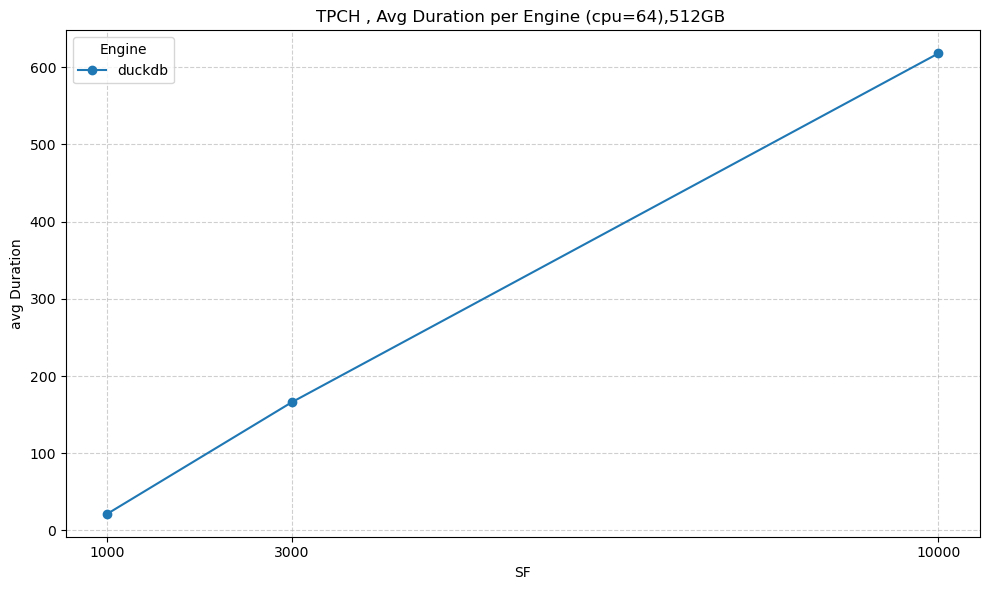

In [15]:
import matplotlib.pyplot as plt
df = DeltaTable(result_path).to_pandas(filters=[("test", "==", "tpch"),("cpu", "==", 64), ("sf", ">", 100),("dur", ">", 0)])
final = (
    df.groupby(["Engine", "cpu", "sf", "query"], as_index=False)
    .agg(dur=("dur", "mean"))  # avg(dur) per query
    .groupby(["cpu", "sf", "Engine"], as_index=False)
    .agg(
        nbr_queries=("query", "nunique"),
        avg=("dur", "mean"),
        total=("dur", "sum")
    )
    .sort_values(by=["sf", "Engine"])
)
print(final)
plt.figure(figsize=(10,6))
for engine, g in final.groupby("Engine"):
    plt.plot(g["sf"], g["avg"], marker="o", label=engine)
plt.xticks(sorted(final["sf"].unique()))  
plt.xlabel("SF")
plt.ylabel("avg Duration")
plt.title(f"TPCH , Avg Duration per Engine (cpu={core}),{core*8}GB ")
plt.legend(title="Engine")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
